[University of Helsinki](https://www.helsinki.fi/) course
[FYS2029 Quantum Computing](https://studies.helsinki.fi/courses/cur/hy-opt-cur-2021-4a22bb2d-b481-44ce-a487-809dd90f2127/Quantum_Computing)
project work: quantum neural networks

[Quantum machine learning](https://en.wikipedia.org/wiki/Quantum_machine_learning)
is the application of quantum computing to solve machine learning problems.
It is a promising field of study, as with carefully designed algorithms
quantum computing can theoretically offer a significant speedup
in the time complexity of various machine-learning related tasks.
This includes both entire data pipelines and
crucial parts of existing machine learning algorithms, such as
[matrix multiplication](https://arxiv.org/abs/1803.01601), which in existing large-scale
machine learning systems is implemented by highly specialized circuitry
([Google](https://en.wikipedia.org/wiki/Tensor_Processing_Unit),
[Nvidia](https://developer.nvidia.com/tensor-cores),
[AMD](https://www.amd.com/en/technologies/cdna)).

Thanks to its high potential, quantum machine learning is being investigated and
developed by various projects and initiatives, including the
[CERN Quantum Technology Initiative](https://quantum.cern/).
Consequently quantum machine learning is an active area of interest for LHC physicists
working on various problems related to both the design and data analysis of the collider, and
they are organizing various
[seminars](https://indico.cern.ch/event/1029154/)
to discuss their results.

I chose this particular topic for the project work, as
machine learning analysis of LHC data is among my possible MSc (and hopefully PhD) thesis topics,
and I wanted to have a look at whether quantum computing would be useful in such research.

Despite the grand promises of quantum computing, the present quantum computers,
also known as
[noisy intermediate-scale quantum (NISQ)](https://doi.org/10.22331/q-2018-08-06-79)
devices, are very limited in their numbers of qubits and quantum gates.
Consequently at present,
quantum computing is used to replace small sections of existing algorithms
to test its potential in various applications.
Regarding algorithm development, it should also be noted, that quantum simulators are
not as well optimized as classical machine learning algorithms, and therefore
classical algorithms are significantly faster on classical hardware.

This project work focuses on the use of quantum circuits to replace some or all layers of a neural network.
The resulting algorithm is known as a quantum neural network.
The library used for the quantum computing is
[TensorFlow Quantum](https://www.tensorflow.org/quantum),
which is the quantum extension of the highly popular machine learning framework
[TensorFlow](https://www.tensorflow.org/).

Working on this project also made it clear, that the quantum machine learning libraries
are still on very early stages of their development, and they are more than a bit rough
around the edges.
For example, each version of TensorFlow Quantum is compatible only with specific
versions of Python and TensorFlow, and some versions have dependency conflicts with
the version of TensorFlow they are designed to be used with.
It should also be noted, that each version of TensorFlow is compatible only with specific
versions of
[CUDA](https://developer.nvidia.com/cuda-zone),
[ROCm](https://rocmdocs.amd.com/en/latest/)
and other libraries, and therefore finding a combination of versions
that works on a given computer can be difficult, and may require installing
specific versions of GPU drivers.
Consequently, getting the necessary libraries to run can be a significant task.
Please have a look at the *requirements.txt* and the
GitHub workflow configurations (*.github/workflows/main.yml*)
for details and installation examples.

The quantum neural network and code below are largely based on the article
[Classification with Quantum Neural Networks on Near Term Processors](http://arxiv.org/abs/1802.06002) by Farhi et al.,
and the TensorFlow Quantum
[MNIST example](https://www.tensorflow.org/quantum/tutorials/mnist),
as machine learning data pipelines require quite a bit of boilerplate code,
and starting from scratch would be very prone to design errors in the
selection of the neural network properties such the counts of layers and neurons in each layer.
These are also known as
[hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)).
However, the code has been significantly modified to
- analyze different datasets
- test different neural network architectures
- make it more reusable by moving the functions to separate Python modules and generalizing the functions to work on different input parameters
- make it more readable and easier to understand with various comments and explanations.

In addition to this project, I have experimented with the other TensorFlow Quantum examples,
and these files are available in the *examples* folder.

First we have to load the necessary libraries.
Some additional libraries may be used in the other modules of this project,
and a full list of required libraries is available in the *requirements.txt* file.

In [2]:
# This tells Jupyter to display Matplotlib plots within the notebook
%matplotlib inline

import importlib

import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq

# These are the other modules of this project
import data
import machine_learning
import quantum

First let's load and pre-process the datasets.
We are training a binary classifier, and therefore we filter only the images
representing the numbers 3 and 6.

Number of original training examples: 60000
Number of original test examples: 10000
True


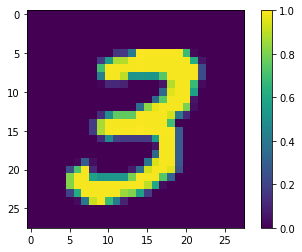

In [3]:
importlib.reload(data)
(x_train, y_train), (x_test, y_test) = data.load_data()

x_train, y_train = data.filter_36(x_train, y_train)
x_test, y_test = data.filter_36(x_test, y_test)

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

At the present, the number of qubits in quantum computers is very limited,
and therefore we scale the images down to 4x4 so that they can
be processed with 16 input qubits + 1 readout qubit = 17 qubits.

Scaling down the data results in some images having the same pixel values, despite being from different categories.
We therefore have to remove the images that could be classified as both 3 and 6 to ensure,
that each image is either a 3 or a 6.

True
Number of unique images: 10387
Number of unique images with label True: 4912
Number of unique images with label False: 5426
Number of unique contradicting labels (both labels):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


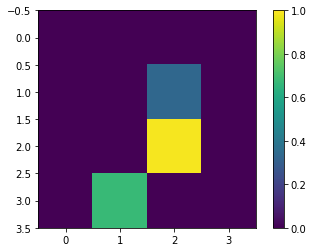

In [4]:
SCALED_SIZE = (4, 4)

# Downscaling
x_train_small = tf.image.resize(x_train, SCALED_SIZE).numpy()
x_test_small = tf.image.resize(x_test, SCALED_SIZE).numpy()

# The category label of the first image
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

x_train_nocon, y_train_nocon = data.remove_contradicting(x_train_small, y_train)

To further simplify the data, we set an intensity threshold for each pixel,
and convert the images from grayscale to black-and-white (binary).
Now we can convert the images to quantum circuits by flipping the qubits with Pauli X gates, also known as NOT gates.
As an example, the first image is represented by the qubits (3,2) and (4,1) being set to 1, and
the rest of the qubits to 0.

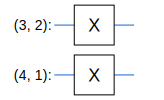

In [5]:
importlib.reload(quantum)

THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

x_train_circ = [quantum.convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [quantum.convert_to_circuit(x) for x in x_test_bin]

SVGCircuit(x_train_circ[0])

The quantum neural network is the core of the algorithm.
In this simple example we use only two densely connected layers, both of which
are connected from the input qubits to one readout qubit.
In the first layer the qubits are connected by XX gates, and in the second layer by ZZ gates.
These gates are also known as the
[Ising coupling gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Ising_coupling_gates),
and they are defined as
<!-- This LaTeX code is from the Wikipedia page -->
\begin{equation}
R_{xx}(\phi) = \exp\left(-i \frac{\phi}{2} X\otimes X\right)= \cos\left(\frac{\phi}{2}\right)I\otimes I-i \sin\left(\frac{\phi}{2}\right)X\otimes X
= \begin{bmatrix}
\cos\left(\frac{\phi}{2}\right) & 0 & 0 & -i \sin\left(\frac{\phi}{2}\right) \\
0 &\cos\left(\frac{\phi}{2}\right) & -i \sin\left(\frac{\phi}{2}\right) & 0 \\
0 & -i \sin\left(\frac{\phi}{2}\right) & \cos\left(\frac{\phi}{2}\right) & 0 \\
-i \sin\left(\frac{\phi}{2}\right) & 0 & 0 & \cos\left(\frac{\phi}{2}\right) \\
\end{bmatrix}
\end{equation}
\begin{equation}
R_{yy}(\phi) = \exp\left(-i \frac{\phi}{2} Y\otimes Y\right)= \begin{bmatrix}
\cos\left(\frac{\phi}{2}\right) & 0 & 0 & i\sin\left(\frac{\phi}{2}\right) \\
0 & \cos\left(\frac{\phi}{2}\right) & -i\sin\left(\frac{\phi}{2}\right) & 0 \\
0 & -i\sin\left(\frac{\phi}{2}\right) & \cos\left(\frac{\phi}{2}\right) & 0 \\
i\sin\left(\frac{\phi}{2}\right) & 0 & 0 & \cos\left(\frac{\phi}{2}\right) \\
\end{bmatrix}
\end{equation}
\begin{equation}
R_{zz}(\phi) = \exp\left(-i \frac{\phi}{2} Z\otimes Z\right) = \begin{bmatrix}
e^{-i \phi/2} & 0 & 0 & 0 \\
0 & e^{i \phi/2} & 0 & 0 \\
0 & 0 & e^{i \phi/2} & 0 \\
0 & 0 & 0 & e^{-i \phi/2} \\
\end{bmatrix}
\end{equation}

The phase angles are the parameters that are adjusted during the learning process.
In a classical neural network they would correspond to the connection weights.
In Cirq they are represented by symbolic Sympy variables.
It should be noted, that the Ising coupling gates
[can be implemented directly](http://www.nature.com/articles/nature18648)
on some trapped-ion quantum computers, which is promising for the gate depth
and therefore the decoherence properties of these quantum neural networks.
In other types of quantum computers, the Ising coupling gates can be constructed by
[combining Pauli gates and CNOT gates](https://quantumcomputing.stackexchange.com/questions/6775/how-to-create-an-ising-coupling-gate-with-qiskit).

Let's build a small demo circuit with four input qubits and one densely connected XX-layer
to demonstrate the network layout discussed above.
This demo circuit is shown below,
as the actual circuit with its 17 qubits and multiple layers
would be too large to display properly.

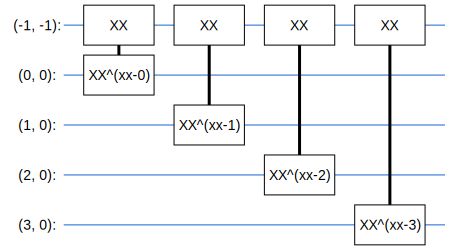

In [6]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

demo_builder = quantum.CircuitLayerBuilder(
    data_qubits = cirq.GridQubit.rect(4,1),
    readout=cirq.GridQubit(-1,-1)
)

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Let's now define the actual quantum circuit and convert it to a Keras model.
This model has no configurable classical layers, so it's entirely quantum-based.
More advanced algorithms could combine classical and quantum layers.
For example, a classical convolutional neural network could have quantum layers as its final dense layers,
or quantum data could be pre-processed by quantum layers before being fed to a classical network.

The choice of layers and other hyperparameters depends highly on the type and internal structure of the data,
and in actual use-cases is often based on either intuition of an experienced machine learning specialist,
or brute-force hyperparameter searches.
The latter is among the primary reasons, why machine learning is so compute-intensive, as
the networks have to re-trained each time the hyperparameters are changed, although
this can be simplified by
[transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning).

In [7]:
importlib.reload(machine_learning)

model_circuit, model_readout = quantum.create_quantum_model(SCALED_SIZE)

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[machine_learning.hinge_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


Let's also experiment with a slightly more complex circuit
that has YY gates in addition to the XX and ZZ gates.
Please see *quantum.py* for the exact layer definitions.

In [8]:
importlib.reload(quantum)

model_circuit2, model_readout2 = quantum.create_quantum_model2(SCALED_SIZE)

# Build the Keras model.
model2 = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit2, model_readout2),
])
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[machine_learning.hinge_accuracy]
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


The model is now configured, and can be trained.
This takes several minutes.

In [9]:
NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=3,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge)
)
qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 82s 252ms/step - loss: 0.9120 - hinge_accuracy: 0.6413 - val_loss: 0.3811 - val_hinge_accuracy: 0.8861

Let's also train the second model.
This takes even longer, as the number of gates and
therefore also the number of trainable parameters are higher.

In [10]:
qnn_history2 = model2.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=3,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge)
)
qnn_results2 = model2.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 78s 240ms/step - loss: 0.9166 - hinge_accuracy: 0.6338 - val_loss: 0.4623 - val_hinge_accuracy: 0.7686

Let's create a classical neural network to compare the performance of the quantum algorithms to a classical one.

In [11]:
importlib.reload(machine_learning)

cnn_model = machine_learning.create_classical_model()
cnn_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

Let's train the classical model. This takes several minutes.

In [12]:
importlib.reload(machine_learning)

cnn_model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=1,
    verbose=1,
    validation_data=(x_test, y_test)
)
cnn_results = cnn_model.evaluate(x_test, y_test)

62/62 [==============================] - 3s 29ms/step - loss: 0.0025 - accuracy: 1.0000 


Let's also use a newer classical network from the Keras examples.

In [13]:
importlib.reload(machine_learning)

cnn_model2 = machine_learning.create_classical_model2(x_train[0].shape)
cnn_model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
cnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Let's train the second classical model

In [14]:
cnn_model2.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=15,
    verbose=1,
    validation_data=(x_test, y_test)
)
cnn_results2 = cnn_model2.evaluate(x_test, y_test)


Epoch 1/15
95/95 [==============================] - 6s 38ms/step - loss: 0.6352 - accuracy: 0.5053 - val_loss: 0.5468 - val_accuracy: 0.5132


For a fair comparison, let's create a classical model with similar restrictions as the quantum one.

In [15]:
fair_model = machine_learning.create_fair_classical_model(SCALED_SIZE)
fair_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
fair_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


Training the fair classical model is much faster that training the quantum model, as
the libraries for classical neural networks are highly optimized and GPU-accelerated.
This should take only a few seconds with GPU acceleration.

In [16]:
fair_model.fit(
    x_train_bin,
    y_train_nocon,
    batch_size=128,
    epochs=20,
    verbose=2,
    validation_data=(x_test_bin, y_test)
)
fair_nn_results = fair_model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 0s - loss: 0.6225 - accuracy: 0.5251 - val_loss: 0.6018 - val_accuracy: 0.4868
Epoch 2/20
81/81 - 0s - loss: 0.5802 - accuracy: 0.5250 - val_loss: 0.5638 - val_accuracy: 0.4868
Epoch 3/20
81/81 - 0s - loss: 0.5420 - accuracy: 0.5258 - val_loss: 0.5290 - val_accuracy: 0.4868
Epoch 4/20
81/81 - 0s - loss: 0.5070 - accuracy: 0.5267 - val_loss: 0.4975 - val_accuracy: 0.4873
Epoch 5/20
81/81 - 0s - loss: 0.4764 - accuracy: 0.5279 - val_loss: 0.4696 - val_accuracy: 0.4898
Epoch 6/20
81/81 - 0s - loss: 0.4497 - accuracy: 0.5296 - val_loss: 0.4445 - val_accuracy: 0.4903
Epoch 7/20
81/81 - 0s - loss: 0.4261 - accuracy: 0.7661 - val_loss: 0.4222 - val_accuracy: 0.8028
Epoch 8/20
81/81 - 0s - loss: 0.4053 - accuracy: 0.8354 - val_loss: 0.4018 - val_accuracy: 0.8130
Epoch 9/20
81/81 - 0s - loss: 0.3806 - accuracy: 0.8430 - val_loss: 0.3654 - val_accuracy: 0.8145
Epoch 10/20
81/81 - 0s - loss: 0.3198 - accuracy: 0.8506 - val_loss: 0.2877 - val_accuracy: 0.8267
Epoch 11/20
81/81 -

Finally we can compare the performance of the neural networks.
The first classical neural network is nearly fully accurate, and both the quantum models and the
fair classical model suffer from the downscaling of the input data, as it significantly
limits the information available to the neural network.
The quantum neural networks have similar performance, and therefore
simply adding YY gates to the quantum neural network does not significantly affect the results.
The second neural network suffers from very slow learning and the results don't therefore differ
much from random classification.
This is a good example, that despite the fact that the network works well for the entire MNIST dataset,
simple modifications to the initial data can have significant consequences on the results.

However, despite the fact that classical neural networks are very difficult to beat for classical data,
there are particular use cases, where quantum neural networks can outperform classical algorithms,
even with the highly limited number of qubits available with current quantum computers.
Quantum computers shine especially when the input data is already quantum,
as then quantum machine learning algorithms can take advantage of the full quantum information,
whereas classical algorithms would be limited to the classical results of measurements from the
quantum data source.
This disparity is showcased in the TensorFlow Quantum example of
[quantum convolutional neural networks](https://www.tensorflow.org/quantum/tutorials/qcnn).

<AxesSubplot:>

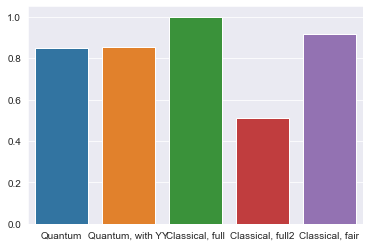

In [17]:
qnn_accuracy = qnn_results[1]
qnn_accuracy2 = qnn_results2[1]
cnn_accuracy = cnn_results[1]
cnn_accuracy2 = cnn_results2[1]
fair_nn_accuracy = fair_nn_results[1]

# Make Seaborn label texts visible on PyCharm with the dark theme.
sns.set_style("darkgrid")

sns.barplot(
    x=["Quantum", "Quantum, with YY", "Classical, full", "Classical, full2", "Classical, fair"],
    y=[qnn_accuracy, qnn_accuracy2, cnn_accuracy, cnn_accuracy2, fair_nn_accuracy]
)

Let's also test these networks with a slightly different dataset.
In 2020, Qiskit organized a
[hackathon challenge](https://medium.com/qiskit/the-qiskit-challenge-india-proved-the-best-way-to-learn-is-by-doing-fe5926010a23)
to identify the numbers 4 and 9 apart from the MNIST dataset.
Let's see, how these neural networks compare to the
[winning](https://www.hackerearth.com/challenges/competitive/qiskit-challenge-finale-week/leaderboard/qiskit-challenge-finale-2-097df07a/)
[submission](https://github.com/Qiskit-Challenge-India/2020/blob/master/top%2011%20submissions/Ashish%20Kumar%20Barnawal/custom_model_full.ipynb)
of the hackathon.

In [18]:
# Loading the data
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, y_train = data.filter_49(x_train, y_train)
x_test, y_test = data.filter_49(x_test, y_test)

# Preprocessing of data
x_train_small = tf.image.resize(x_train, SCALED_SIZE).numpy()
x_test_small = tf.image.resize(x_test, SCALED_SIZE).numpy()
x_train_nocon, y_train_nocon = data.remove_contradicting(x_train_small, y_train)

# Quantum conversion of data
x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)
x_train_circ = [quantum.convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [quantum.convert_to_circuit(x) for x in x_test_bin]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

model_circuit, model_readout = quantum.create_quantum_model(SCALED_SIZE)

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[machine_learning.hinge_accuracy])

# model.summary()

# Second neural network

model_circuit2, model_readout2 = quantum.create_quantum_model2(SCALED_SIZE)

# Build the Keras model.
model2 = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit2, model_readout2),
])
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[machine_learning.hinge_accuracy]
)

# model2.summary()

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Number of original training examples: 60000
Number of original test examples: 10000
Number of unique images: 10961
Number of unique images with label True: 5302
Number of unique images with label False: 5505
Number of unique contradicting labels (both labels):  154

Initial number of images:  11791
Remaining non-contradicting unique images:  10807


Training the models

In [19]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=3,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge)
)
qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 54s 164ms/step - loss: 0.9744 - hinge_accuracy: 0.5537 - val_loss: 0.8976 - val_hinge_accuracy: 0.5663

In [20]:
qnn_history2 = model2.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=3,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge)
)
qnn_results2 = model2.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 76s 235ms/step - loss: 1.0000 - hinge_accuracy: 0.4746 - val_loss: 1.0000 - val_hinge_accuracy: 0.5325

Classical models

In [21]:
importlib.reload(machine_learning)

cnn_model = machine_learning.create_classical_model()
cnn_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
# cnn_model.summary()

cnn_model2 = machine_learning.create_classical_model2(x_train[0].shape)
cnn_model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
# cnn_model2.summary()

fair_model = machine_learning.create_fair_classical_model(SCALED_SIZE)
fair_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
# fair_model.summary()

Training of classical models


In [22]:
cnn_model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=1,
    verbose=1,
    validation_data=(x_test, y_test)
)
cnn_results = cnn_model.evaluate(x_test, y_test)

cnn_model2.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=15,
    verbose=1,
    validation_data=(x_test, y_test)
)
cnn_results2 = cnn_model2.evaluate(x_test, y_test)

fair_model.fit(
    x_train_bin,
    y_train_nocon,
    batch_size=128,
    epochs=20,
    verbose=2,
    validation_data=(x_test_bin, y_test)
)
fair_nn_results = fair_model.evaluate(x_test_bin, y_test)

63/63 [==============================] - 2s 32ms/step - loss: 0.0248 - accuracy: 0.9864
Epoch 1/15
93/93 [==============================] - 4s 45ms/step - loss: 0.6529 - accuracy: 0.4914 - val_loss: 0.5541 - val_accuracy: 0.4932

Let's compare the results for this dataset.
As expected, the winning VQC-based submission beats these simple neural networks,
but loses to the classical neural network.
Both quantum neural networks have similar performance.
Overall, the results are similar as for the first dataset.

<AxesSubplot:>

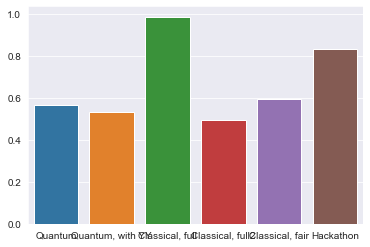

In [23]:
qnn_accuracy = qnn_results[1]
qnn_accuracy2 = qnn_results2[1]
cnn_accuracy = cnn_results[1]
cnn_accuracy2 = cnn_results2[1]
fair_nn_accuracy = fair_nn_results[1]
# From:
# https://www.hackerearth.com/challenges/competitive/qiskit-challenge-finale-week/leaderboard/qiskit-challenge-finale-2-097df07a/
hackathon_accuracy = 0.83200

# Make Seaborn label texts visible on PyCharm with the dark theme.
sns.set_style("darkgrid")

sns.barplot(
    x=["Quantum", "Quantum, with YY", "Classical, full", "Classical, full2", "Classical, fair", "Hackathon"],
    y=[qnn_accuracy, qnn_accuracy2, cnn_accuracy, cnn_accuracy2, fair_nn_accuracy, hackathon_accuracy]
)

Initially I had planned to test these quantum neural networks with various other problems,
such as the classification of different fruits and Pokemon.
However, the datasets I found were designed for multiclass classification from a dataset of only a few high-resolution images.
Therefore the data was too complex to be processed by the small quantum neural networks that are available with
present quantum computers and simulators.